# Example Notebook to demonstrate the usage of the SimpleGenericGenerator implementation

This example notebook demonstrates the use of the `SimpleGenericGenerator` class to generate Item-Response curves for a given input image, perturber and scorer metric.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Sample input image and detection](#sample-input-image-and-detection)
* [Initialize pipeline instances](#initialize-pipeline-instances)
* [Generate and Visualize Item-Response curves](#generate-and-visualize-item-response-curves)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/examples/simple_generic_generator.ipynb)

## Environment Setup <a name="environment-setup"></a>

**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](./README.md) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" torchvision
print("Done!")

Installing nrtk...
Installing torch and torchvision...
Done!


## Sample input image and detection <a name="sample-input-image-and-detection"></a>

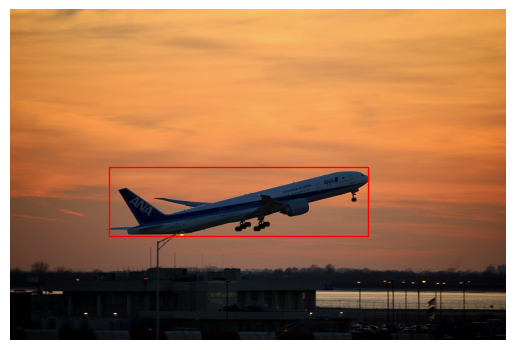

In [3]:
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

url = 'https://data.kitware.com/api/v1/item/6596fde79c30d6f4e17c9ef9/download'

img_path = os.path.join(data_dir, 'example.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
img = np.asarray(Image.open(img_path))

gt = [[(AxisAlignedBoundingBox([255, 406], [924, 583]), {"category": "airplane"})]]
bbox = gt[0][0][0]
width = bbox.max_vertex[0] - bbox.min_vertex[0]
height = bbox.max_vertex[1] - bbox.min_vertex[1]

fig, ax = plt.subplots()
ax.imshow(img)  # type: ignore
ax.set_axis_off()  # type: ignore
ax.add_patch(Rectangle(  # type: ignore
                (bbox.min_vertex[0], bbox.min_vertex[1]),
                width,
                height,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )) 
plt.show()

## Initialize pipeline instances <a name="initialize-pipeline-instances"></a>

In the cell below, we initialize the model, perturber, perturber factory, generator and the scorer instances needed for our pipeline.

In [4]:
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN
from nrtk.impls.perturb_image_factory.generic.step import StepPerturbImageFactory
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber
from nrtk.impls.gen_object_detector_blackbox_response.simple_generic_generator import SimpleGenericGenerator
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer

img_batch_size = 1

perturber_factory = StepPerturbImageFactory(perturber=GaussianBlurPerturber, theta_key='ksize', start=1, stop=151, step=2)

detector = ResNetFRCNN(use_cuda=False, num_dets=1)
detector.get_model()

scorer = ClassAgnosticPixelwiseIoUScorer()

generator = SimpleGenericGenerator(images=[img], groundtruth=gt) # type: ignore


## Generate and Visualize Item-Response curves <a name="generate-and-visualize-item-response-curves"></a>

Using the initialized pipeline instances from above, we generate and visualize the IRC to see how the `ClassAgnosticPixelwiseIoU` scores are impacted when applying the `GaussianBlurPerturber` on the given input image.

100%|██████████| 75/75 [02:36<00:00,  2.09s/it]


Text(0, 0.5, 'mean ClassAgnosticPixelwiseIoU')

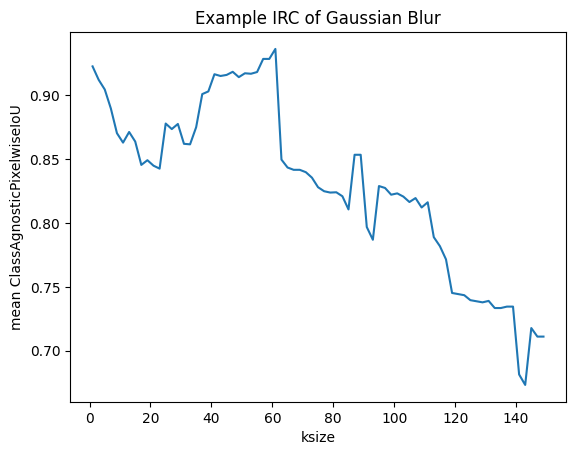

In [5]:
import torch  # type: ignore
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

curve, full = generator(
                blackbox_perturber_factories=[perturber_factory],
                blackbox_detector=detector,
                blackbox_scorer=scorer,
                img_batch_size=img_batch_size,
                verbose=True
            )

x = list()
y = list()
for data in curve:
    x.append(data[0]['ksize'])
    y.append(data[1])

plt.cla()
plt.plot(x, y)
plt.title('Example IRC of Gaussian Blur')
plt.xlabel('ksize')
plt.ylabel('mean ClassAgnosticPixelwiseIoU')